In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from matplotlib.animation import FuncAnimation, PillowWriter
import plotly.graph_objs as go
from functools import reduce
import teneto




from functions.EpiIndex import *
from functions.Connectivity import *

In [2]:
raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif', preload=True)
#Reading a npy file 
data_alpha = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_alpha_aec_dense.npy')
data_beta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_beta_aec_dense.npy')
data_hgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_high_gamma1_aec_dense.npy')
data_lgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_low_gamma_aec_dense.npy')
data_theta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_theta_aec_dense.npy')

data_alpha_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_alpha_aec_distance_dense.npy')
data_beta_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_beta_aec_distance_dense.npy')
data_hgamma_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_high_gamma1_aec_distance_dense.npy')
data_lgamma_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_low_gamma_aec_distance_dense.npy')
data_theta_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_theta_aec_distance_dense.npy')
# Reading the .tsv file 
xyz_loc = pd.read_csv('/home/pablo/works/dev_thesis_SEEG/data/pte_01/others/sEEG_locs_filtered.tsv', sep='\t')


#Data with other metrics
data_coh = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/SR_subseg_connectivity_data_high_freq_coh_dense.npy')[:,:,:,0]
# Assuming data is the array with shape (50, 127, 127)
for i in range(data_coh.shape[0]):
    # Extract the lower triangular part (including the diagonal)
    lower_triangular = np.tril(data_coh[i])
    
    # Mirror the lower triangular part to the upper triangular part
    data_coh[i] = lower_triangular + lower_triangular.T - np.diag(np.diag(lower_triangular))

#Make data_coh symmetric

# con_data=np.mean(data,axis=3)
raw.drop_channels(["lp'11", "lp'12", "op'12", "pi'18", "pa'12"])

Opening raw data file /home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif...
Isotrak not found
    Range : 2546688 ... 2731008 =   4974.000 ...  5334.000 secs
Ready.


/tmp/ipykernel_11046/3470177540.py:1: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif', preload=True)


Reading 0 ... 184320  =      0.000 ...   360.000 secs...


Measurement date,"May 20, 2024 02:11:21 GMT"
Experimenter,Unknown
Participant,Sara
Digitized points,Not available
Good channels,122 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.15 Hz
Lowpass,134.00 Hz


In [65]:
from teneto import TemporalNetwork
data=data_hgamma_norm
#Preparing data node,node,time
data=data.transpose(1,2,0)
tnet_bu= TemporalNetwork(N=data.shape[0],T=data.shape[2],nettype='wu',from_array=data,
                      timetype='discrete',timeunit='epoch', nodelabels=list(xyz_loc['formatted_label'].values))

tnet_bu.binarize(threshold_type='percent',threshold_level=0.10)

tnet_wu=TemporalNetwork(N=data.shape[0],T=data.shape[2],nettype='wu',from_array=data,
                      timetype='discrete',timeunit='epoch', nodelabels=list(xyz_loc['formatted_label'].values))



/tmp/ipykernel_11046/3304238309.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


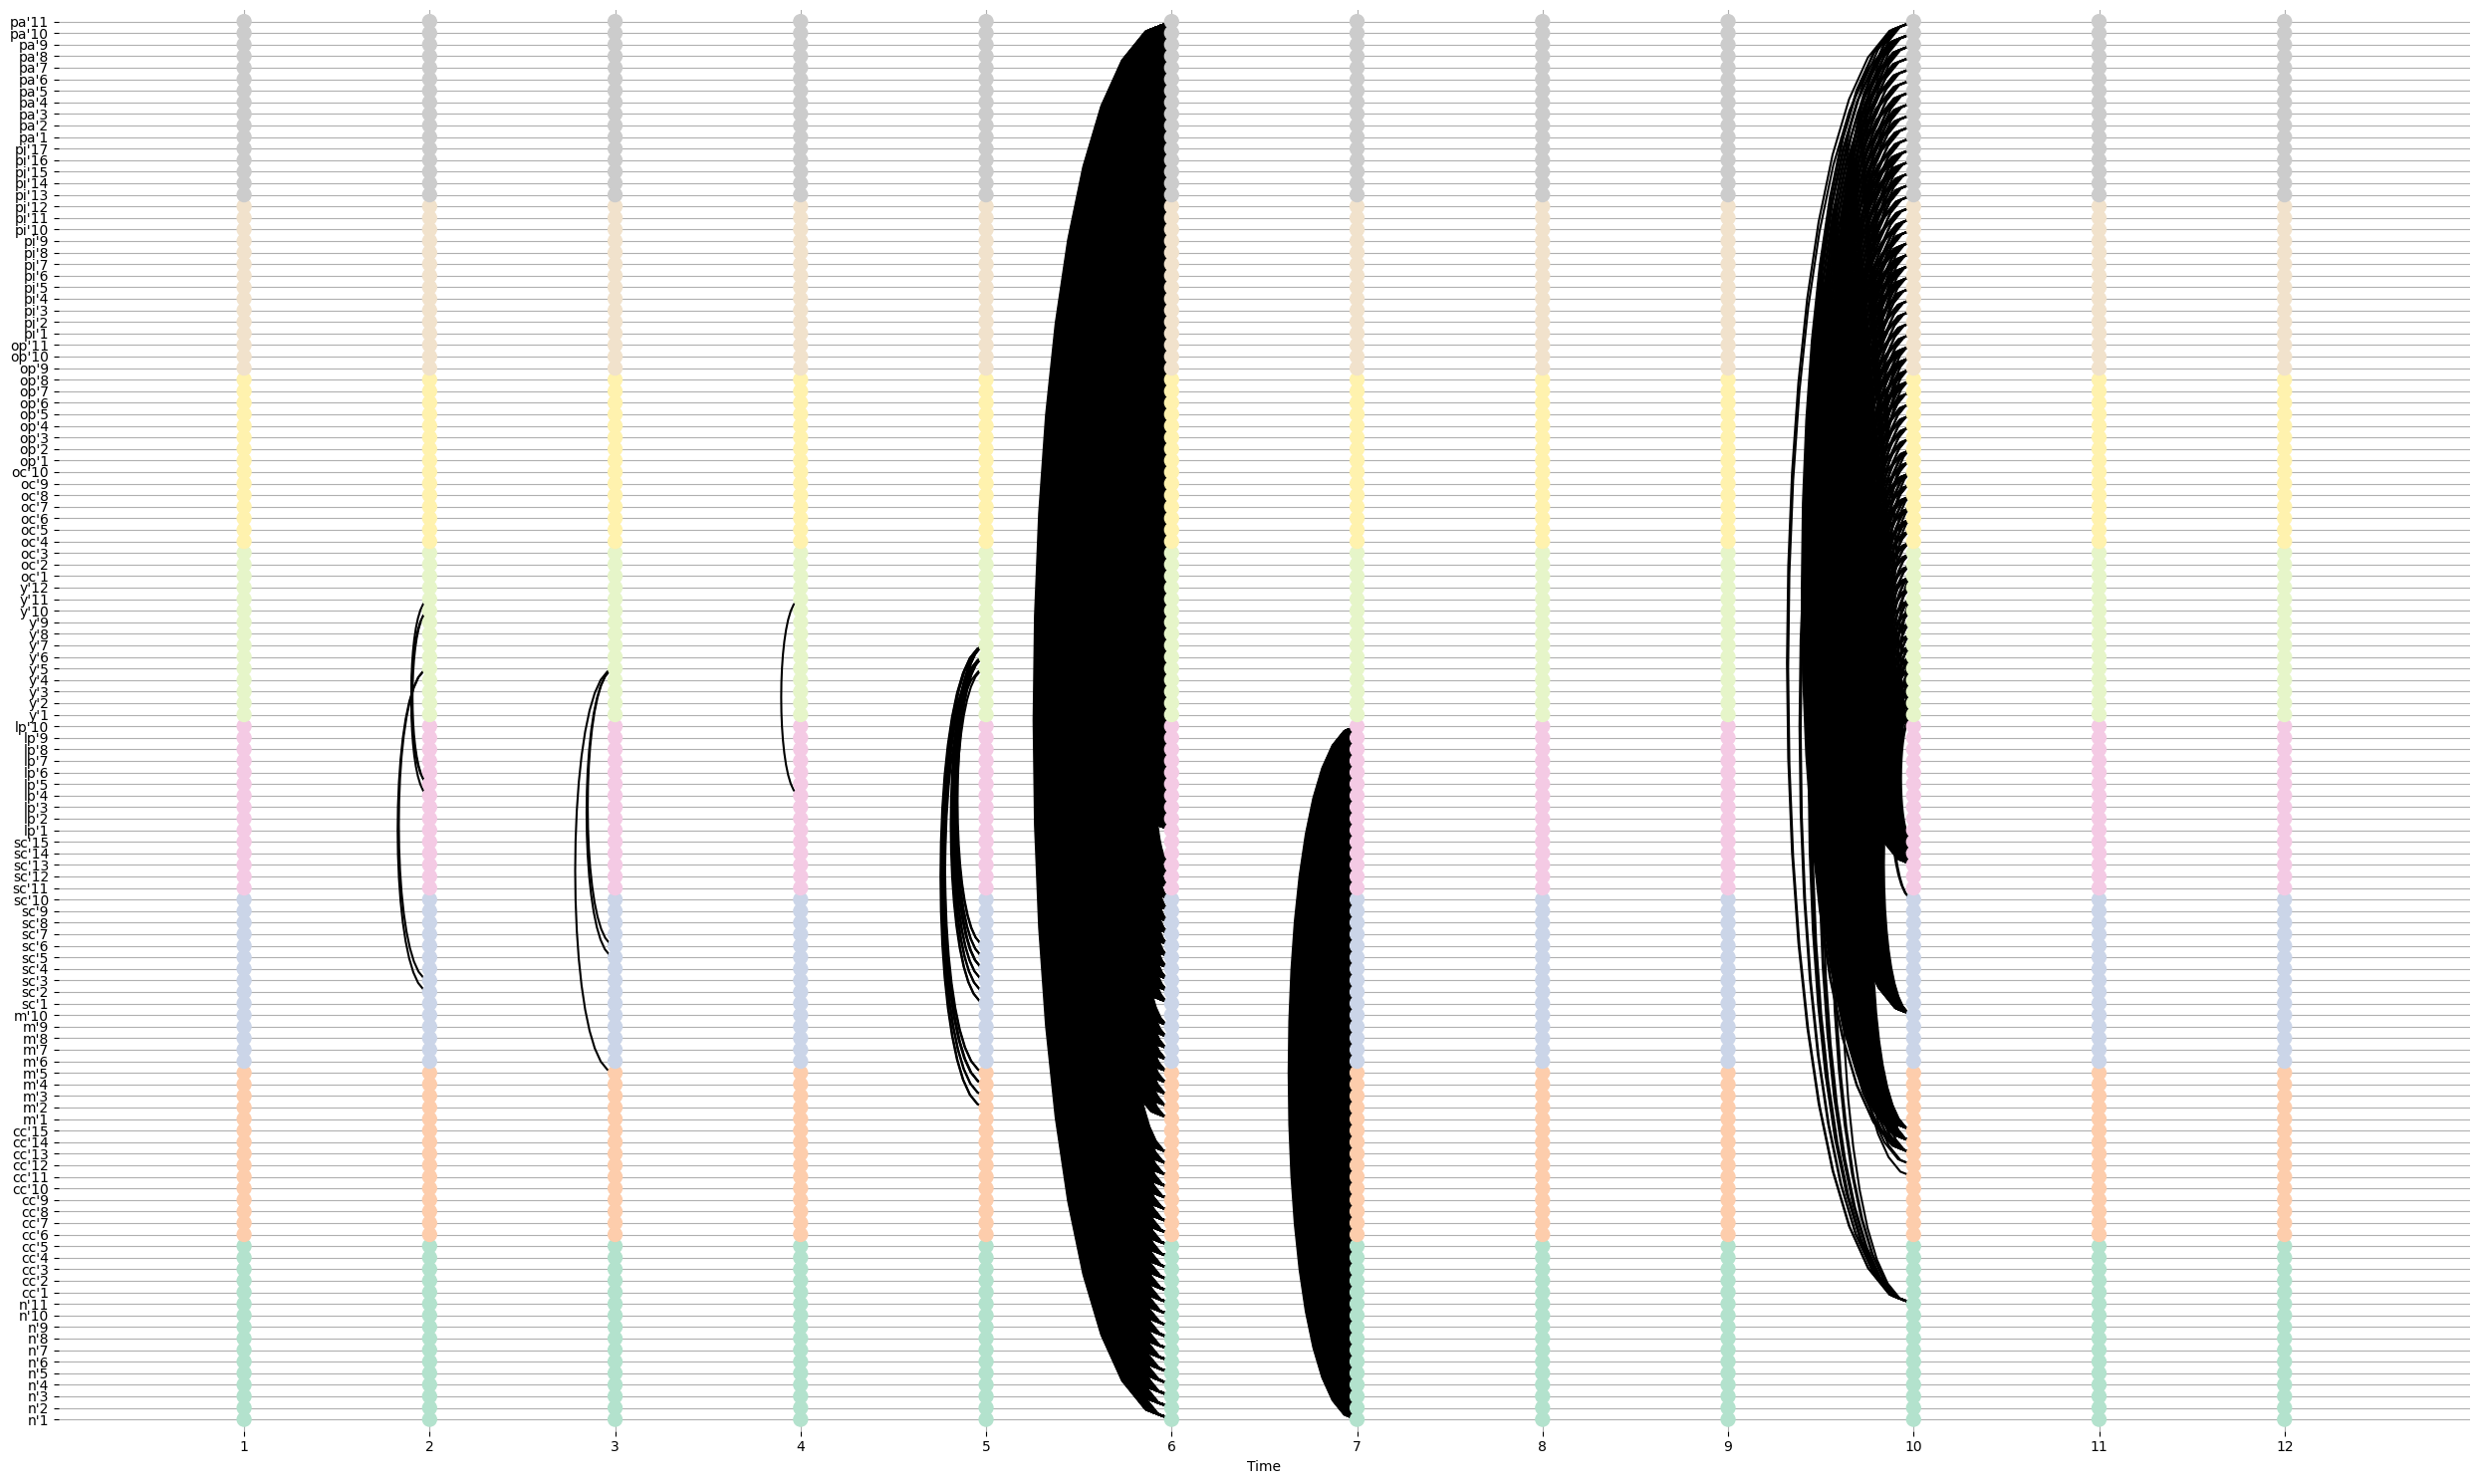

In [66]:
#Ploting the graph
from teneto import plot 

fig,ax = plt.subplots(figsize=(25,15))
ax = plot.slice_plot(tnet_bu.network, ax, plotedgeweights=False,cmap='Pastel2', nodelabels=list(xyz_loc['formatted_label'].values))
plt.tight_layout()
fig.show()

2024-09-18 23:25:05,695 [ WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005531487580236621..1.0000000000000007].
/tmp/ipykernel_11046/243036797.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


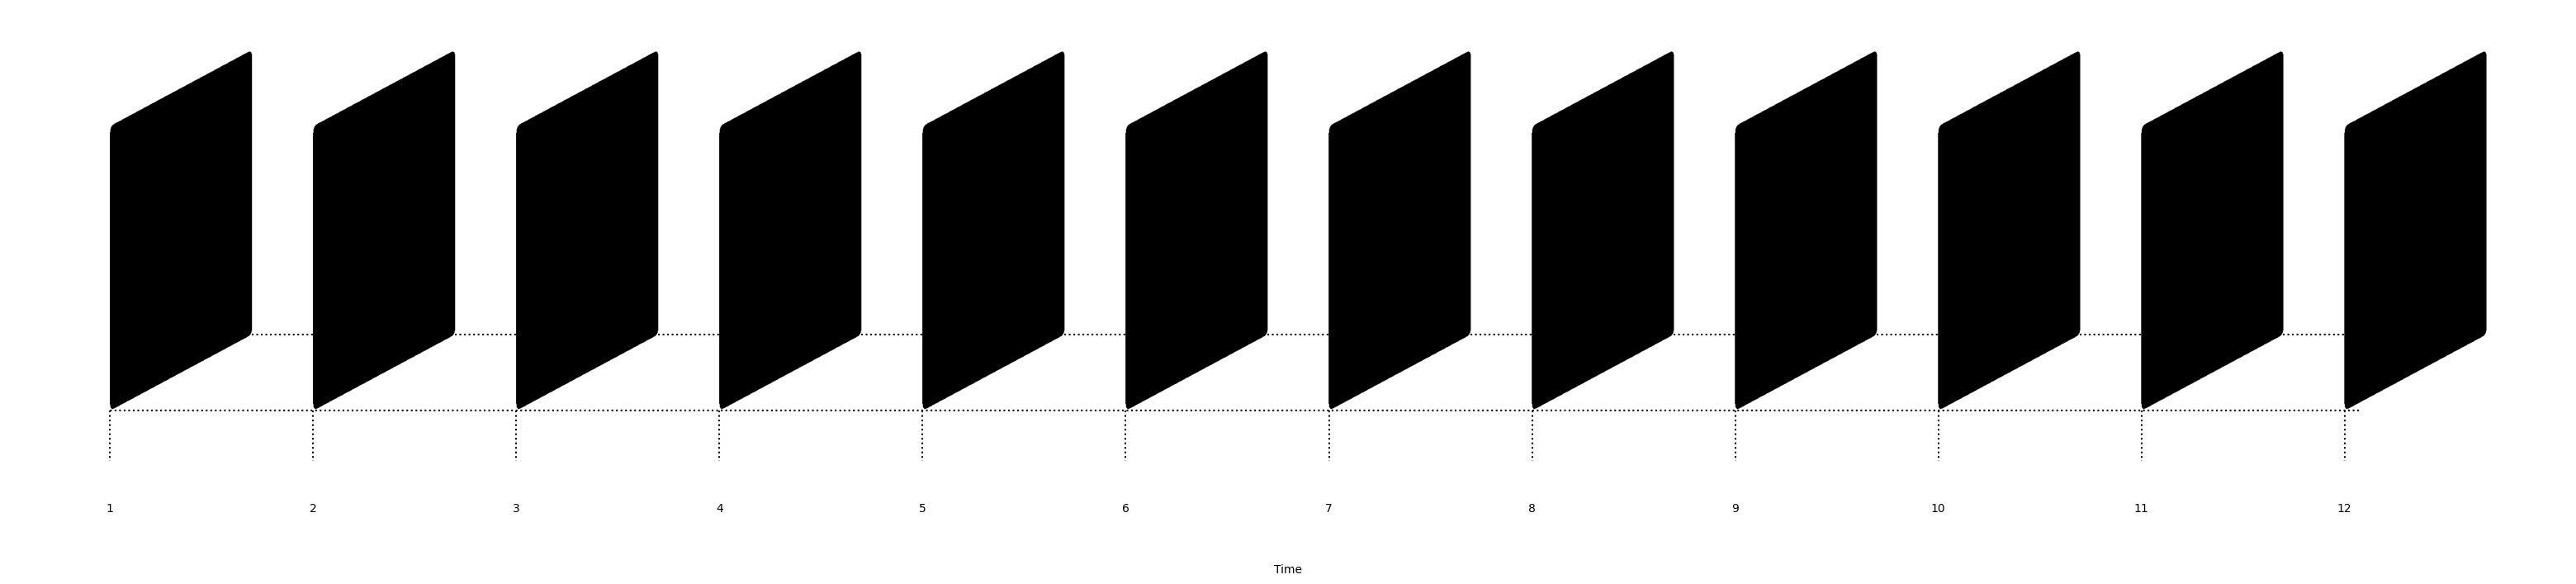

In [67]:
fig,ax = plt.subplots(figsize=(40,30))
ax = teneto.plot.graphlet_stack_plot(tnet_bu.network,ax,cmap='Reds', gridcolor='k')
fig.show()

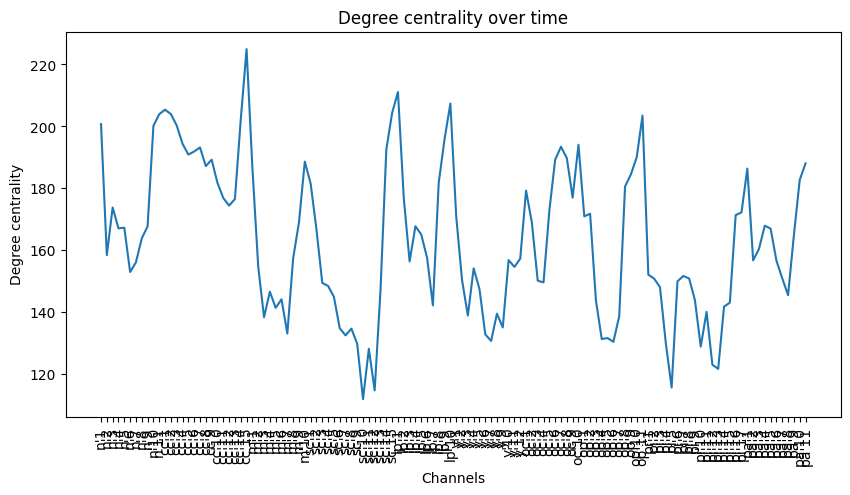

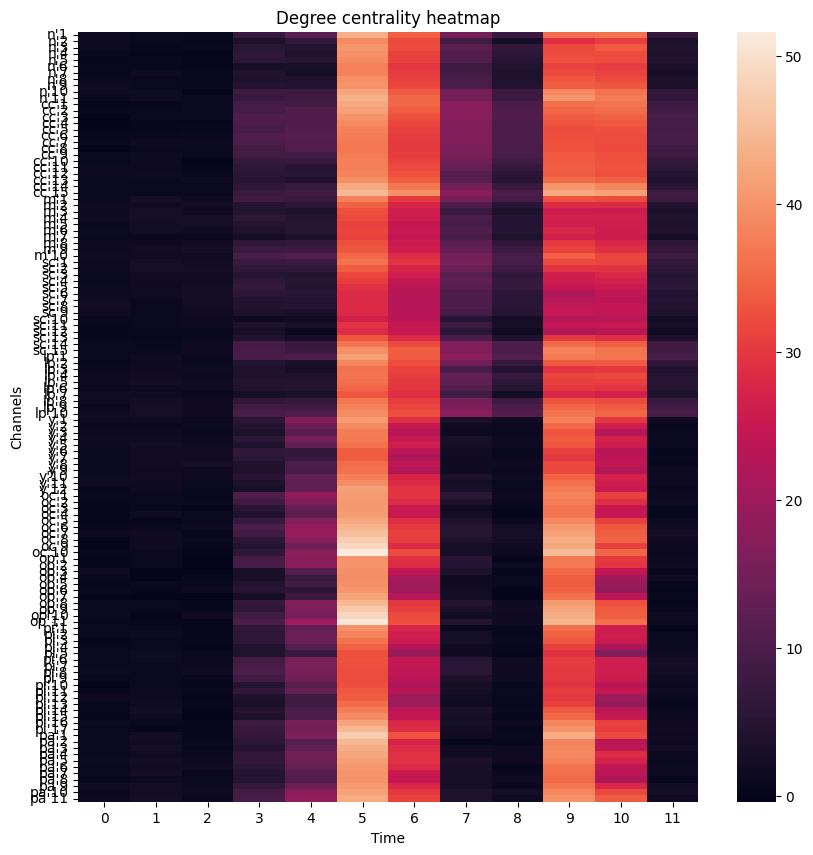

In [68]:
from teneto import networkmeasures as nwm
#Centrality measures 
degree_centrality_1=nwm.temporal_degree_centrality(tnet_wu,calc='overtime')
#Plotting the degree centrality
plt.figure(figsize=(10,5))
plt.plot(degree_centrality_1)
plt.title('Degree centrality over time')
plt.xlabel('Channels')
plt.xticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values, rotation=90)
plt.ylabel('Degree centrality')
plt.show()


degree_centrality_2=nwm.temporal_degree_centrality(tnet_wu,calc='pertime')
#Plot a sns.heamap of the degree centrality
plt.figure(figsize=(10,10))
sns.heatmap(degree_centrality_2, yticklabels=xyz_loc['formatted_label'].values, xticklabels=np.arange(0, data.shape[2], 1))
plt.title('Degree centrality heatmap')
#Size of the yticks

plt.xlabel('Time')
plt.ylabel('Channels')
plt.show()



In [93]:
#Temporal betweenness centrality
#Network has to be binary

betweenness_centrality_1=nwm.temporal_betweenness_centrality(tnet_bu,calc='overtime')
#Plotting the betweenness centrality


In [ ]:
#Temporal closeness centrality
temporal_closeness_centrality_1=nwm.temporal_closeness_centrality(tnet_bu)

In [ ]:
#Topological overal

In [ ]:
#Bursty coeff
burstiness=nwm.bursty_coeff(tnet_bu,calc='edge')

### Comumnity detection 

In [72]:
#Lovain clustering
communities=teneto.communitydetection.temporal_louvain(tnet_bu, resolution=1,njobs=4,consensus_threshold=0.5)

0
          i     j  weight
0         0     1       1
1       122   123       1
2       244   245       1
3       366   367       1
4       488   489       1
...     ...   ...     ...
63046  1337  1459       0
63047  1338  1460       0
63048  1339  1461       0
63049  1340  1462       0
63050  1341  1463       0

[63051 rows x 3 columns]
1


/home/pablo/miniconda3/envs/Epilep/lib/python3.11/site-packages/teneto/classes/network.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network['i'] = self.network['i'].astype(int)
/home/pablo/miniconda3/envs/Epilep/lib/python3.11/site-packages/teneto/classes/network.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network['j'] = self.network['j'].astype(int)
/home/pablo/miniconda3/envs/Epilep/lib/python3.11/site-packages/teneto/classes/network.py:242: SettingWithCopyWarning: 
A value is

          i     j  weight
0         0     1       1
1       122   123       1
2       244   245       1
3       366   367       1
4       488   489       1
...     ...   ...     ...
63427  1337  1459       0
63428  1338  1460       0
63429  1339  1461       0
63430  1340  1462       0
63431  1341  1463       0

[63432 rows x 3 columns]
2
          i     j  weight
0         0     1       1
1       122   123       1
2       244   245       1
3       366   367       1
4       488   489       1
...     ...   ...     ...
63427  1337  1459       0
63428  1338  1460       0
63429  1339  1461       0
63430  1340  1462       0
63431  1341  1463       0

[63432 rows x 3 columns]


/home/pablo/miniconda3/envs/Epilep/lib/python3.11/site-packages/teneto/classes/network.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network['i'] = self.network['i'].astype(int)
/home/pablo/miniconda3/envs/Epilep/lib/python3.11/site-packages/teneto/classes/network.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network['j'] = self.network['j'].astype(int)


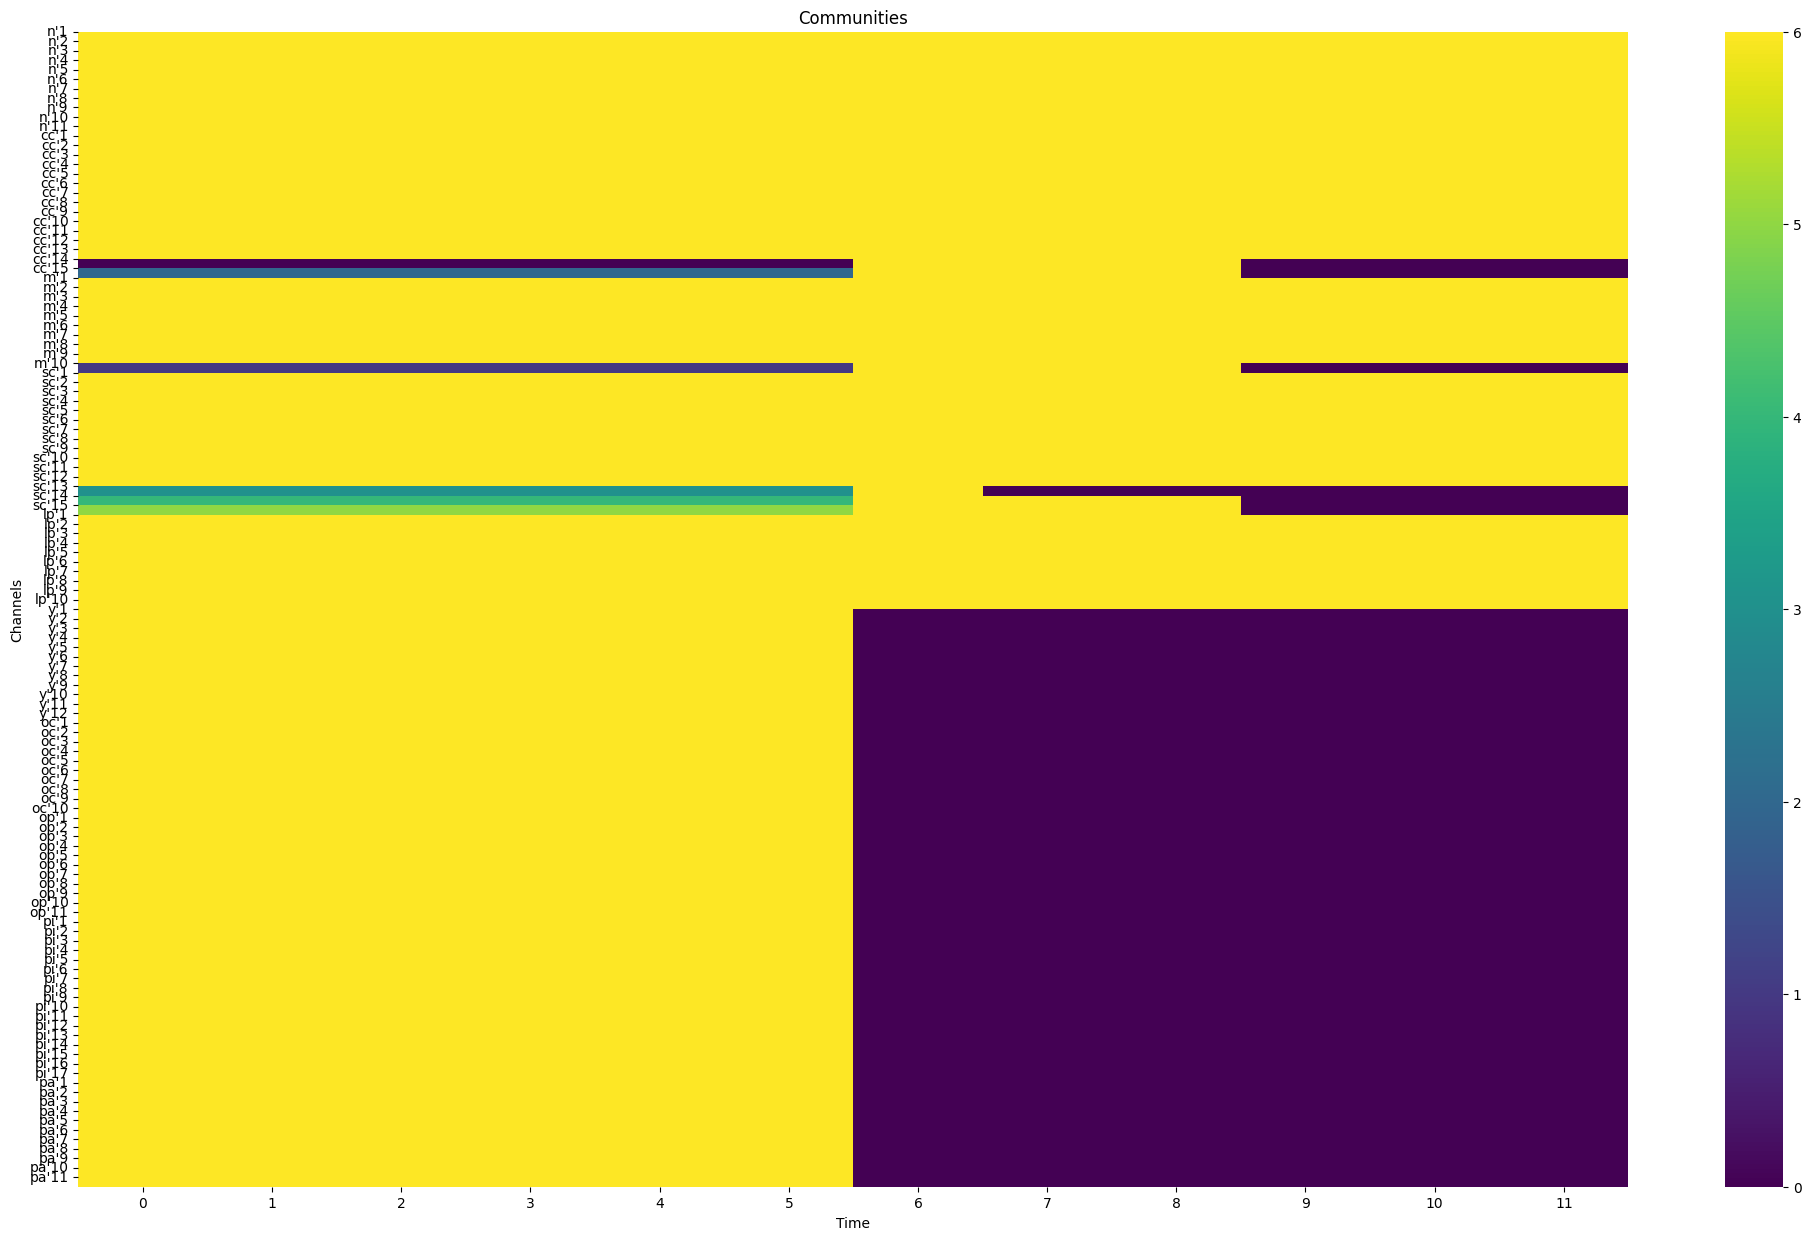

In [73]:
#plotting the communities
fig,ax = plt.subplots(figsize=(25,15))
sns.heatmap(communities,cmap='viridis',ax=ax)
plt.title('Communities')
plt.xlabel('Time')

plt.ylabel('Channels')
plt.yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.show()

#### SubCommunity metrics

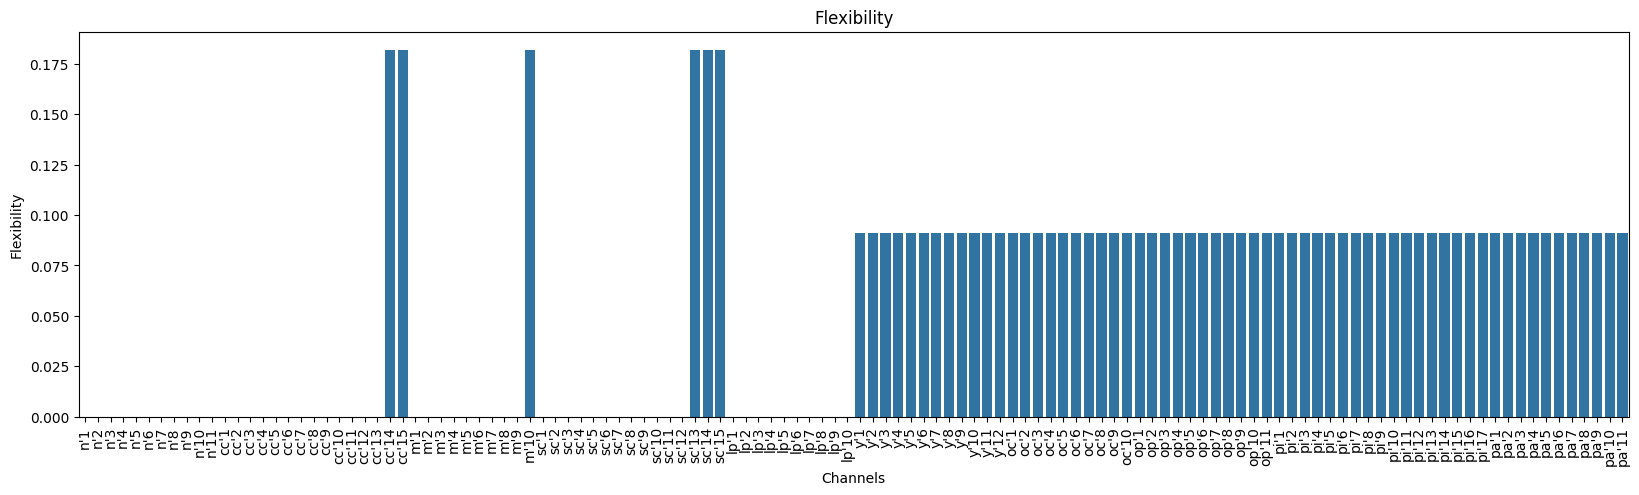

In [74]:
from teneto import communitymeasures
#Community measures
flexibility_m=communitymeasures.flexibility(communities)
plt.figure(figsize=(20,5))
#Plotting the flexibility
sns.barplot(x=xyz_loc['formatted_label'].values, y=flexibility_m)
plt.title('Flexibility')
plt.xlabel('Channels')
plt.ylabel('Flexibility')
plt.xticks(rotation=90)
plt.show()

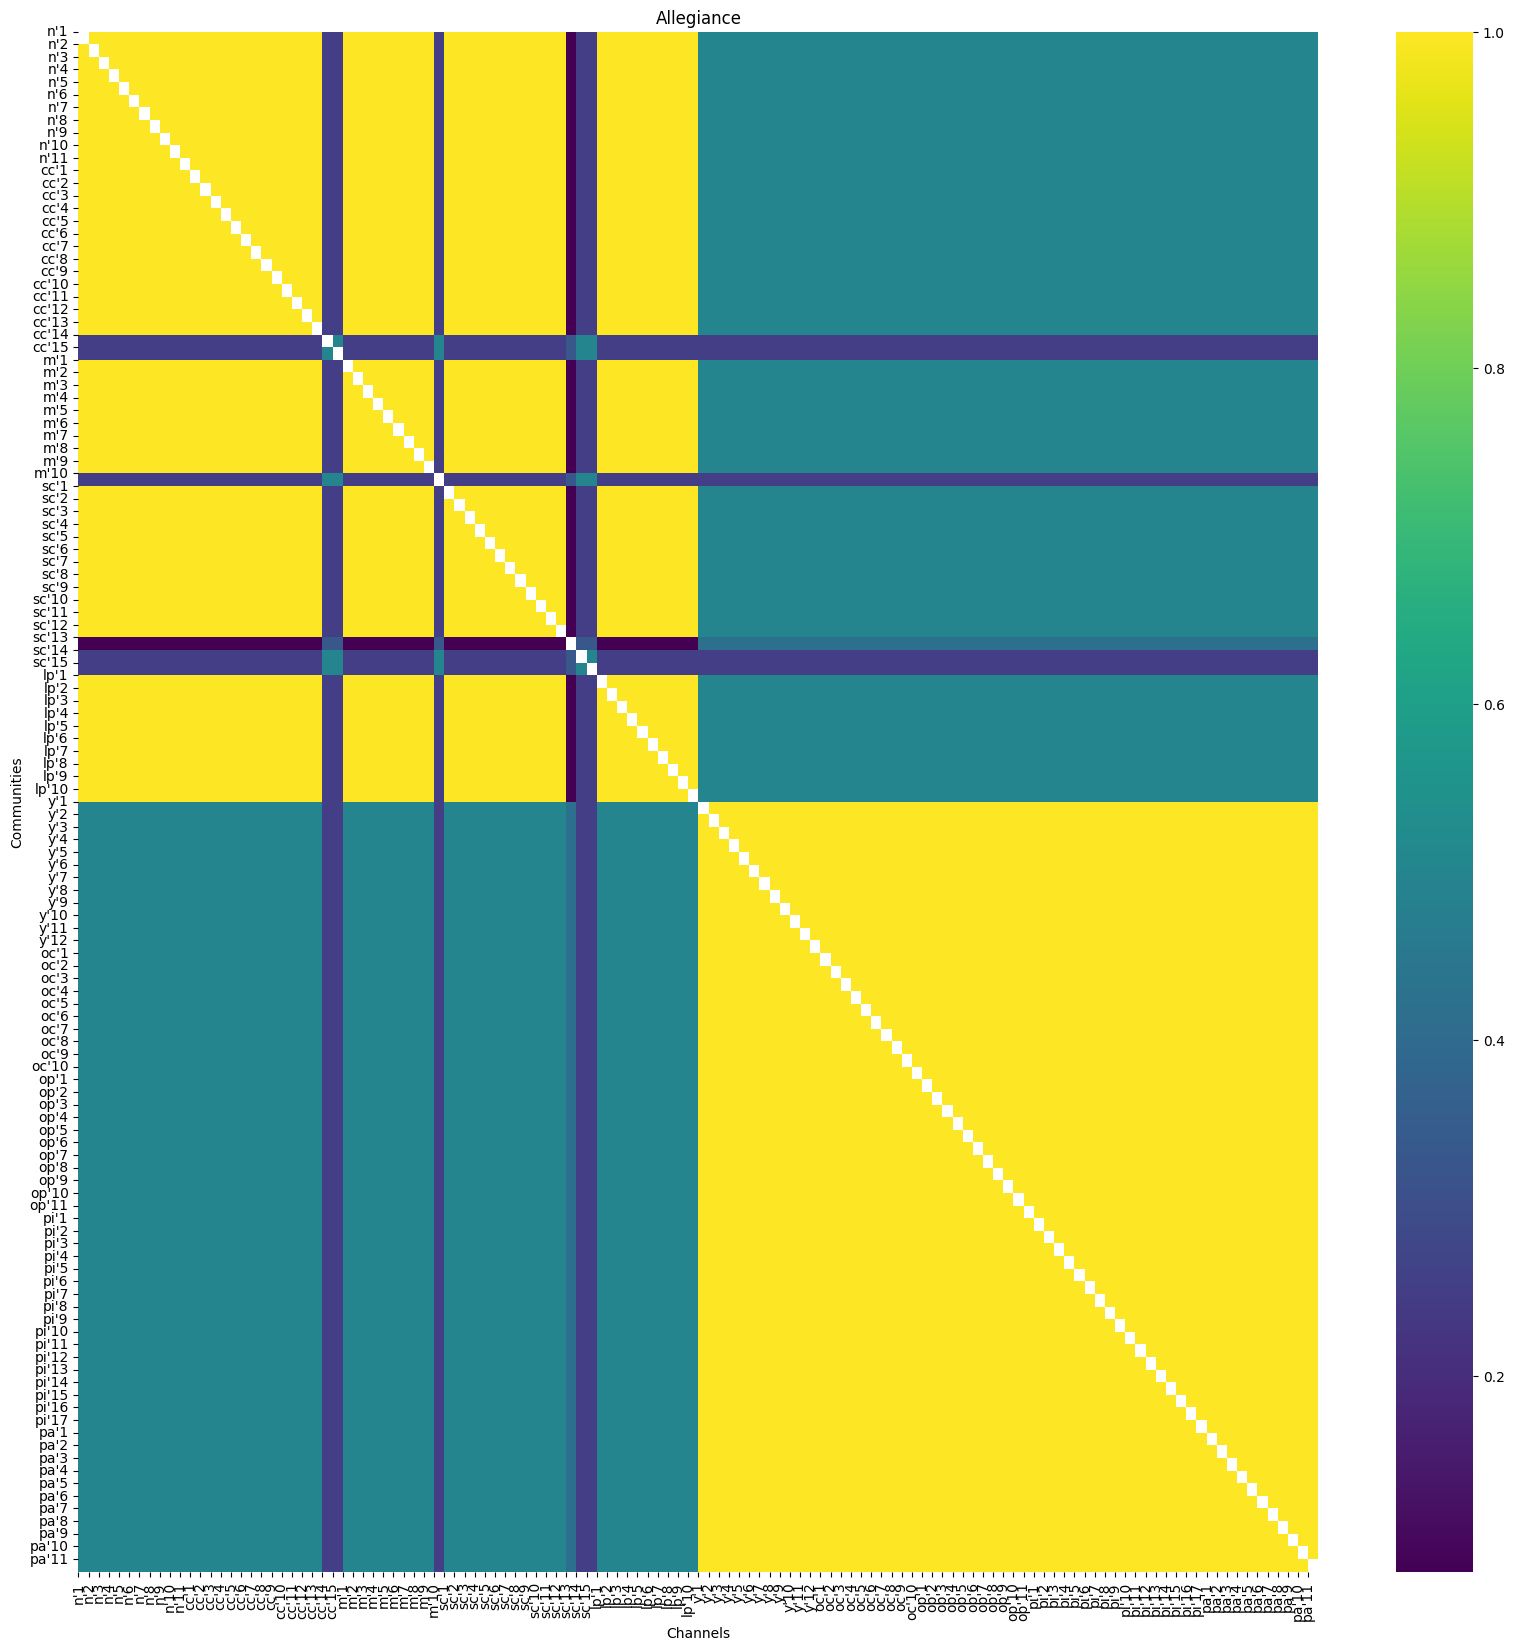

In [80]:
allegiance_m=communitymeasures.allegiance(communities)
plt.figure(figsize=(20,20))
sns.heatmap(allegiance_m,cmap='viridis')
plt.title('Allegiance')
plt.xlabel('Channels')
plt.ylabel('Communities')
plt.yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.xticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.show()

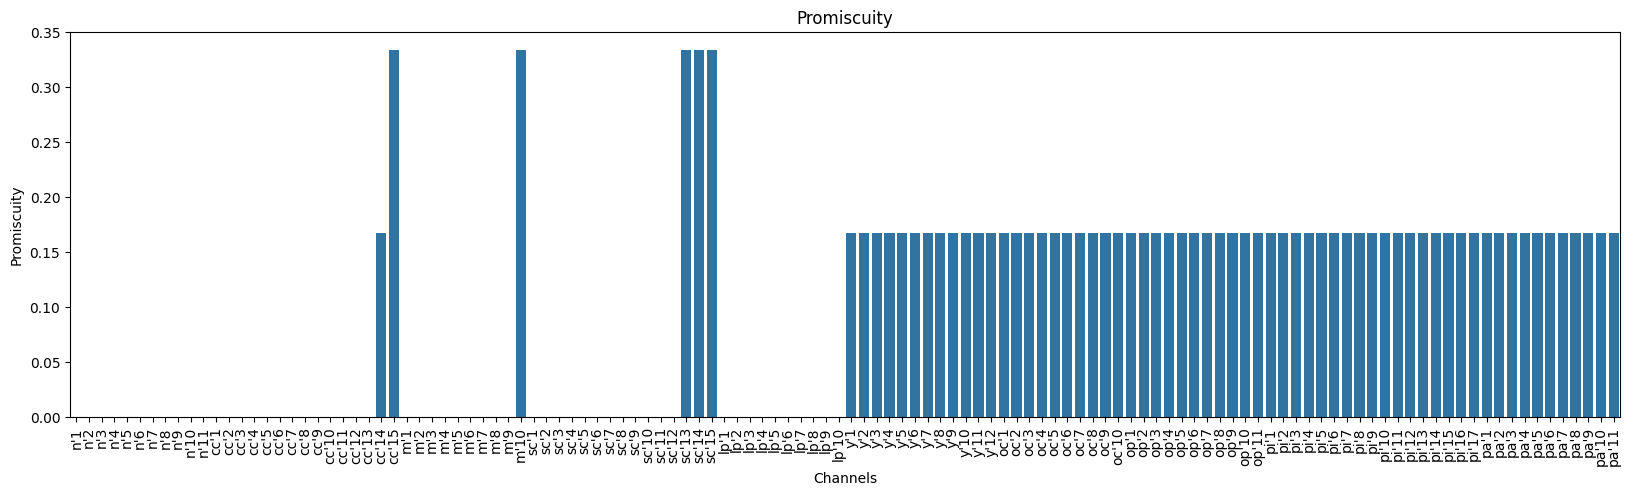

In [84]:
promiscuity_m=communitymeasures.promiscuity(communities)
plt.figure(figsize=(20,5))
sns.barplot(x=xyz_loc['formatted_label'].values, y=promiscuity_m)
plt.title('Promiscuity')
plt.xlabel('Channels')
plt.ylabel('Promiscuity')
plt.xticks(rotation=90)
plt.show()

In [86]:
persistence_mg=communitymeasures.persistence(communities,calc='global')
persistence_mt=communitymeasures.persistence(communities,calc='time')
persistence_mn=communitymeasures.persistence(communities,calc='node')

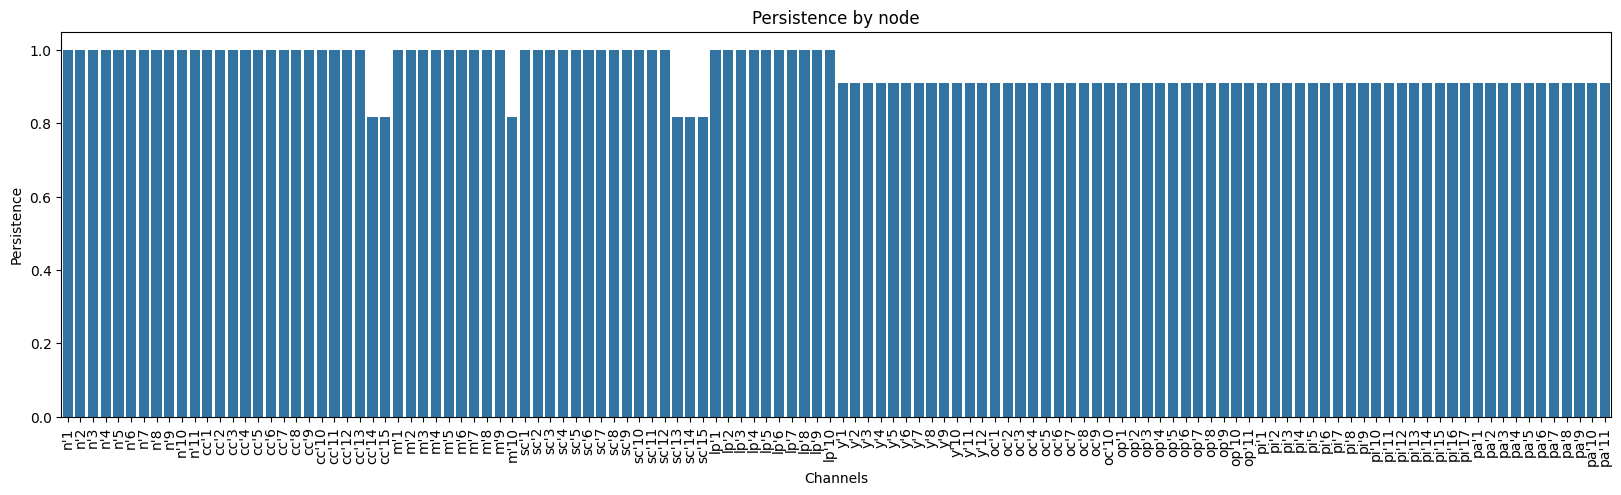

In [90]:
plt.figure(figsize=(20,5))
sns.barplot(x=xyz_loc['formatted_label'].values, y=persistence_mn)
plt.title('Persistence by node')
plt.xlabel('Channels')
plt.ylabel('Persistence')
plt.xticks(rotation=90)
plt.show()

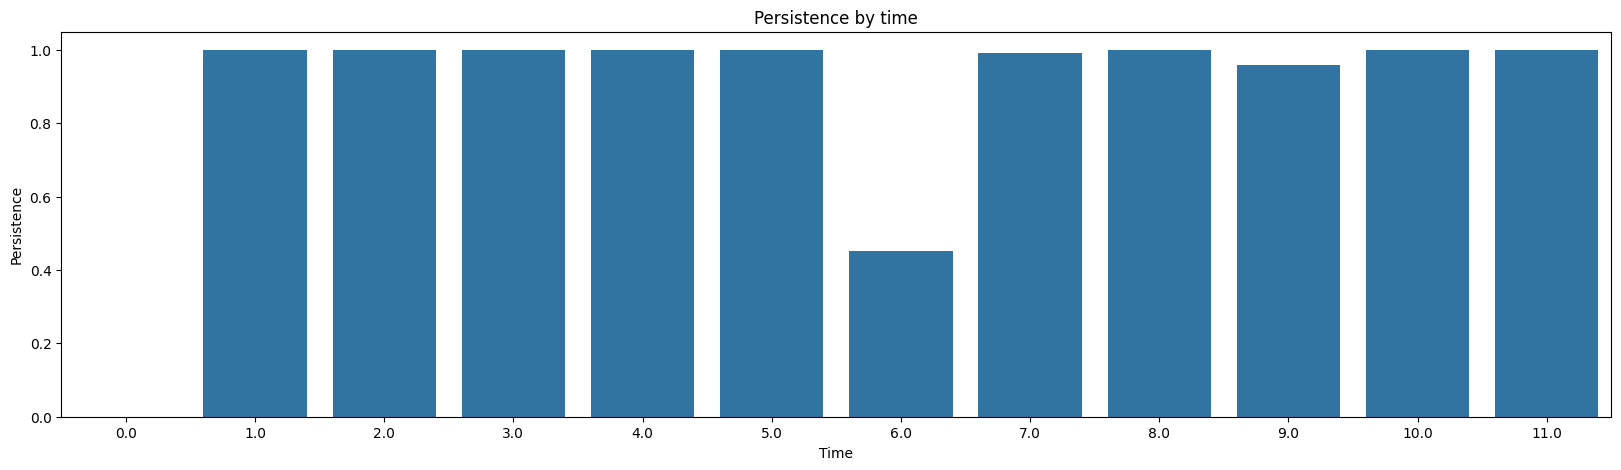

In [92]:
plt.figure(figsize=(20,5))
sns.barplot(x=np.linspace(0, 11, data.shape[2]), y=persistence_mt)   
plt.title('Persistence by time')
plt.xlabel('Time')
plt.ylabel('Persistence')
plt.show()
